In [1]:
import matplotlib.pyplot as plt
import os

from ultralytics import YOLO
import numpy as np

from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from PIL import Image
import matplotlib.patches as patches

import json
from pycocotools.coco import COCO

/home/xavier/python-venvs/doom-venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Analyzing Images

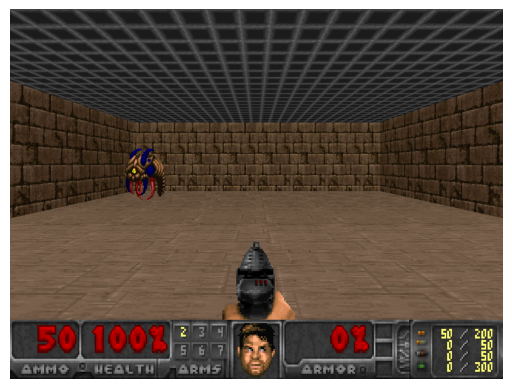

In [2]:
img = plt.imread(os.path.join(os.pardir, "screens", "screen_0001.png"))

plt.imshow(img)
plt.axis('off')
plt.show()

## Testing YOLO Models

In [3]:
# Convert image from float32 (0-1) to uint8 (0-255)
img_uint8 = (img * 255).astype(np.uint8)

# Load the YOLOv8s model
model = YOLO('yolov8s.pt')

# Run inference on the image
results = model(img_uint8)

# Display results
for result in results:
    result.show()
    result.plot()


0: 480x640 2 persons, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 9.8ms postprocess per image at shape (1, 3, 480, 640)


In [4]:
# Convert image from float32 (0-1) to uint8 (0-255)
img_uint8 = (img * 255).astype(np.uint8)

# Load the YOLOv8n model
model = YOLO('yolov8n.pt')

# Run inference on the image
results = model(img_uint8)

# Display results
for result in results:
    result.show()
    result.plot()


0: 480x640 (no detections), 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


## Vision Transformers

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/xavier/python-venvs/doom-venv/lib64/python3.12/site-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/xavier/python-venvs/doom-venv/lib64/python3.12/site-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `

DETR Vision Transformer Detection Results:
Detected 2 objects

  Object 19: confidence 0.54, box [234.6302032470703, 287.2224426269531, 320.4598388671875, 393.7100830078125]
  Object 7: confidence 0.99, box [471.9806823730469, 482.53912353515625, 547.0296630859375, 624.222412109375]


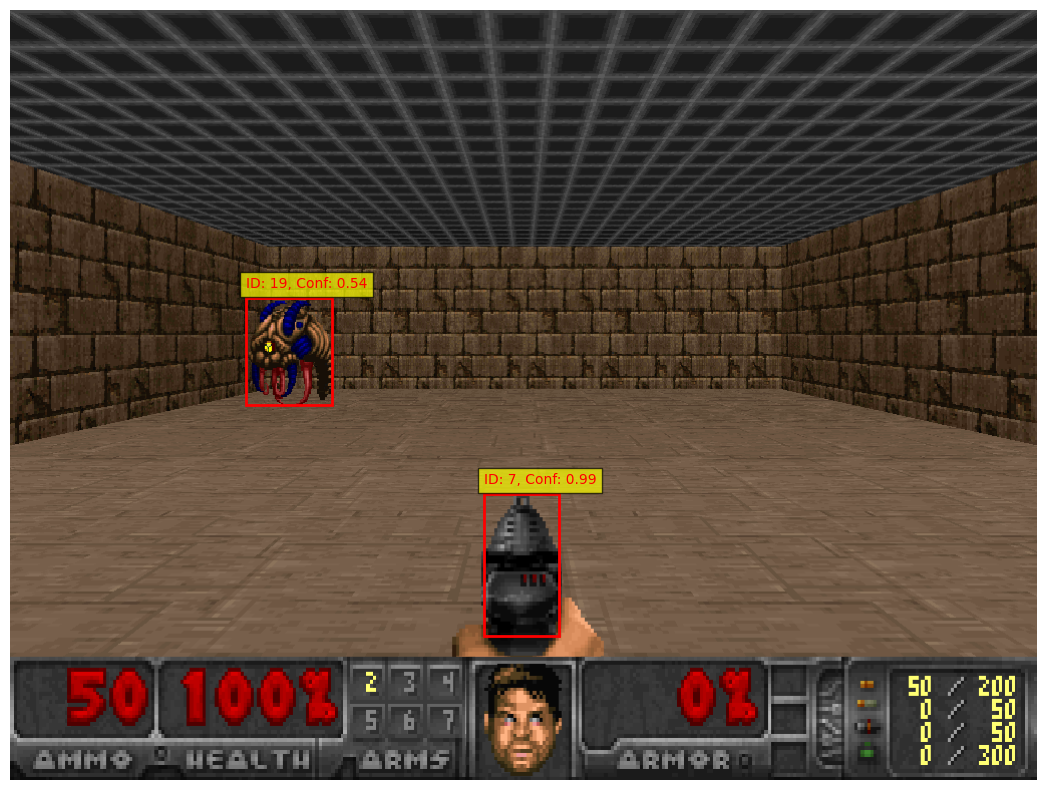

In [5]:
# Load DETR (Detection Transformer) model
# DETR is a transformer-based object detection model that provides an alternative to YOLO
processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
model_detr = AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Convert numpy array to PIL Image for processing
pil_img = Image.fromarray(img_uint8)

# Process the image
inputs = processor(images=pil_img, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model_detr(**inputs)

# Post-process results
target_sizes = torch.tensor([pil_img.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

# Display results with bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(img_uint8)

print("DETR Vision Transformer Detection Results:")
print(f"Detected {len(results['scores'])} objects\n")

# Draw bounding boxes
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    xmin, ymin, xmax, ymax = box.tolist()
    width = xmax - xmin
    height = ymax - ymin
    
    # Create rectangle patch
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, 
                             edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    # Add label with confidence score
    label_text = f"ID: {label.item()}, Conf: {score.item():.2f}"
    ax.text(xmin, ymin - 10, label_text, color='red', fontsize=10, 
            bbox=dict(facecolor='yellow', alpha=0.7))
    
    print(f"  Object {label.item()}: confidence {score.item():.2f}, box {box.tolist()}")

ax.axis('off')
plt.tight_layout()
plt.show()

## Fine-Tuning Using CocoDoom Dataset
- [CocoDoom](https://www.robots.ox.ac.uk/~vgg/research/researchdoom/cocodoom/)

#### Helper Functions for Plotting

#### Helper functions for Training

In [6]:
from torch.optim import AdamW
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, device, epoch):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    
    for batch_idx, (pixel_values, targets) in enumerate(progress_bar):
        # Move to device
        pixel_values = pixel_values.to(device)
        targets = [
            {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                   for k, v in t.items()} for t in targets]
        
        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=targets)
        
        # Loss is computed internally by the model
        loss = outputs.loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def validate(model, dataloader, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for pixel_values, targets in tqdm(dataloader, desc="Validation"):
            pixel_values = pixel_values.to(device)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                       for k, v in t.items()} for t in targets]
            
            outputs = model(pixel_values=pixel_values, labels=targets)
            loss = outputs.loss
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [7]:
class CocoDetection(Dataset):
    """Custom COCO dataset for DETR training."""

    def __init__(self, img_folder, annotation_file, processor, catid2contig, augment=False):
        """
        Args:
            img_folder: Path to image folder
            annotation_file: Path to COCO format JSON annotation file
            processor: DETR image processor for preprocessing
            catid2contig: Mapping from original COCO category ids to contiguous ids
            augment: Whether to apply data augmentation
        """
        self.img_folder = img_folder
        self.coco = COCO(annotation_file)
        self.processor = processor
        self.catid2contig = catid2contig
        self.augment = augment
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Get image info
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_folder, img_info['file_name'])

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Get annotations in COCO format (xywh, absolute pixels)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Filter out crowd / invalid boxes and ensure required keys
        coco_annotations = []
        for ann in anns:
            if ann.get("iscrowd", 0) == 1:
                continue
            if ann.get("bbox") is None:
                continue
            cat_contig = self.catid2contig[ann["category_id"]]
            coco_annotations.append({
                "bbox": ann["bbox"],            # [x, y, w, h] in absolute pixels
                "category_id": cat_contig,       # remapped to contiguous ids
                "area": ann.get("area", ann["bbox"][2] * ann["bbox"][3]),
                "iscrowd": ann.get("iscrowd", 0)
            })

        # Build target in the format expected by the processor
        target = {
            "image_id": img_id,
            "annotations": coco_annotations
        }

        # Process image and target with DETR processor
        encoding = self.processor(images=image, annotations=target, return_tensors="pt")

        # Remove batch dimension added by processor
        pixel_values = encoding["pixel_values"].squeeze(0)
        labels = encoding["labels"][0]

        return pixel_values, labels

In [8]:
def collate_fn(batch):
    """Custom collate function to handle variable number of objects per image."""
    pixel_values = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    return torch.stack(pixel_values), labels


# Load COCO annotations
coco_doom_dataset_path = os.path.join(os.pardir, os.pardir, "datasets", "cocodoom")
train_annotation_file = os.path.join(coco_doom_dataset_path, "run-train.json")
val_annotation_file = os.path.join(coco_doom_dataset_path, "run-val.json")

# Initialize COCO API
coco_train = COCO(train_annotation_file)
coco_val = COCO(val_annotation_file)

print(f"Training set: {len(coco_train.imgs)} images")
print(f"Validation set: {len(coco_val.imgs)} images")
print(f"Categories: {coco_train.loadCats(coco_train.getCatIds())}")

# Build contiguous id mapping (required by DETR loss)
cat_ids = coco_train.getCatIds()
catid2contig = {cid: idx for idx, cid in enumerate(cat_ids)}
contig2catid = {v: k for k, v in catid2contig.items()}

# Label names for config metadata
cats = coco_train.loadCats(cat_ids)
id2label = {idx: cat["name"] for idx, cat in enumerate(cats)}
label2id = {v: k for k, v in id2label.items()}

# Get number of classes from your dataset
num_classes = len(cat_ids)
print(f"Number of classes: {num_classes}")

# Create datasets
# NOTE: we are going to be using the run split,
# meaning run1 is for training and run2 for validation
# img_folder_train = os.path.join(coco_doom_dataset_path, "run1")
# img_folder_val = os.path.join(coco_doom_dataset_path, "run2")

train_dataset = CocoDetection(coco_doom_dataset_path, train_annotation_file, processor, catid2contig)
val_dataset = CocoDetection(coco_doom_dataset_path, val_annotation_file, processor, catid2contig)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

# Create dataloaders
batch_size = 4  # Adjust based on GPU memory
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
Training set: 50732 images
Validation set: 9510 images
Categories: [{'id': 1, 'name': 'POSSESSED', 'supercategory': ''}, {'id': 2, 'name': 'SHOTGUY', 'supercategory': ''}, {'id': 3, 'name': 'VILE', 'supercategory': ''}, {'id': 4, 'name': 'FIRE', 'supercategory': ''}, {'id': 5, 'name': 'UNDEAD', 'supercategory': ''}, {'id': 6, 'name': 'TRACER', 'supercategory': ''}, {'id': 7, 'name': 'SMOKE', 'supercategory': ''}, {'id': 8, 'name': 'FATSO', 'supercategory': ''}, {'id': 9, 'name': 'FATSHOT', 'supercategory': ''}, {'id': 10, 'name': 'CHAINGUY', 'supercategory': ''}, {'id': 11, 'name': 'TROOP', 'supercategory': ''}, {'id': 12, 'name': 'SERGEANT', 'supercategory': ''}, {'id': 14, 'name': 'HEAD', 'supercategory': ''}, {'id': 15, 'name': 'BRUISER', 'supercategory': ''}, {'id': 16, 'name': 'BRUISERSHOT', 'supercategory': ''}, {'id

In [9]:
# Training loop
train_losses = []
val_losses = []

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize processor and model
processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Update config metadata to match custom dataset
model.config.num_labels = num_classes
model.config.id2label = id2label
model.config.label2id = label2id

# Update model's classification head if needed
# DETR uses 91 classes by default (COCO dataset)
# If your dataset has different number of classes, you need to adjust
if model.config.num_labels != num_classes:
    print(
        f"Adjusting model from {model.config.num_labels} to {num_classes} classes")
    model.class_labels_classifier = torch.nn.Linear(
        model.config.d_model, num_classes + 1  # +1 for "no object" class
    )
else:
    # Ensure head matches the updated num_classes when config already set
    model.class_labels_classifier = torch.nn.Linear(
        model.config.d_model, num_classes + 1
    )

model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Training parameters
num_epochs = 10

for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*50}")

    # Train
    train_loss = train_one_epoch(
        model, train_dataloader, optimizer, device, epoch + 1)
    train_losses.append(train_loss)
    print(f"Training Loss: {train_loss:.4f}")

    # Validate
    val_loss = validate(model, val_dataloader, device)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")

    # Save checkpoint
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f"detr_checkpoint_epoch_{epoch + 1}.pt"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

print("\nTraining complete!")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch 1/10


Epoch 1:   4%|▍         | 564/12683 [03:27<1:14:10,  2.72it/s, loss=2.3914]


KeyboardInterrupt: 